# Módulo 6 - Aprendizaje profundo
## Clase 2: ResNet

In [ ]:
import gdown
#https://www.kaggle.com/datasets/rahmasleam/bird-speciees-dataset

url = 'https://drive.google.com/uc?export=download&id=1Ik5_xAR2g4e92tcZHo7MlJSBMfpo3t6m'
destination = "bird-speciees-dataset.zip"
gdown.download(url, destination, quiet=False)

# Descomprimir el dataset
!unzip bird-speciees-dataset.zip -d bird_species_dataset

Downloading...
From: https://drive.google.com/uc?export=download&id=1Ik5_xAR2g4e92tcZHo7MlJSBMfpo3t6m
To: /content/bird-speciees-dataset.zip
100%|██████████| 16.0M/16.0M [00:00<00:00, 49.4MB/s]


Archive:  bird-speciees-dataset.zip
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/001.jpg  
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/002.jpg  
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/003.jpg  
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/004.jpg  
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/005.jpg  
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/006.jpg  
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/007.jpg  
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/008.jpg  
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/009.jpg  
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/010.jpg  
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/011.jpg  
  inflating: bird_species_dat

In [ ]:
# librerias
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
!ls 'bird_species_dataset/Bird Speciees Dataset'

'AMERICAN GOLDFINCH'  'CARMINE BEE-EATER'  'EMPEROR PENGUIN'
'BARN OWL'	      'DOWNY WOODPECKER'    FLAMINGO


In [ ]:
# Cambiar el tamaño de las imágenes a 224x224
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Directorio de datos
data_dir = 'bird_species_dataset/Bird Speciees Dataset'

# Cargar el dataset completo
full_dataset = ImageFolder(data_dir, transform=train_transforms)

In [ ]:
# Dividimos el dataset
train_size = int(0.8 * len(full_dataset))  # 80% para entrenamiento
val_size = len(full_dataset) - train_size  # 20% para validación

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Aplicar transformaciones a val
val_dataset.dataset.transform = val_transforms


In [ ]:
# Crear DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Obtenemos los nombres de las clases
class_names = full_dataset.classes
print("Clases:", class_names)


Clases: ['AMERICAN GOLDFINCH', 'BARN OWL', 'CARMINE BEE-EATER', 'DOWNY WOODPECKER', 'EMPEROR PENGUIN', 'FLAMINGO']


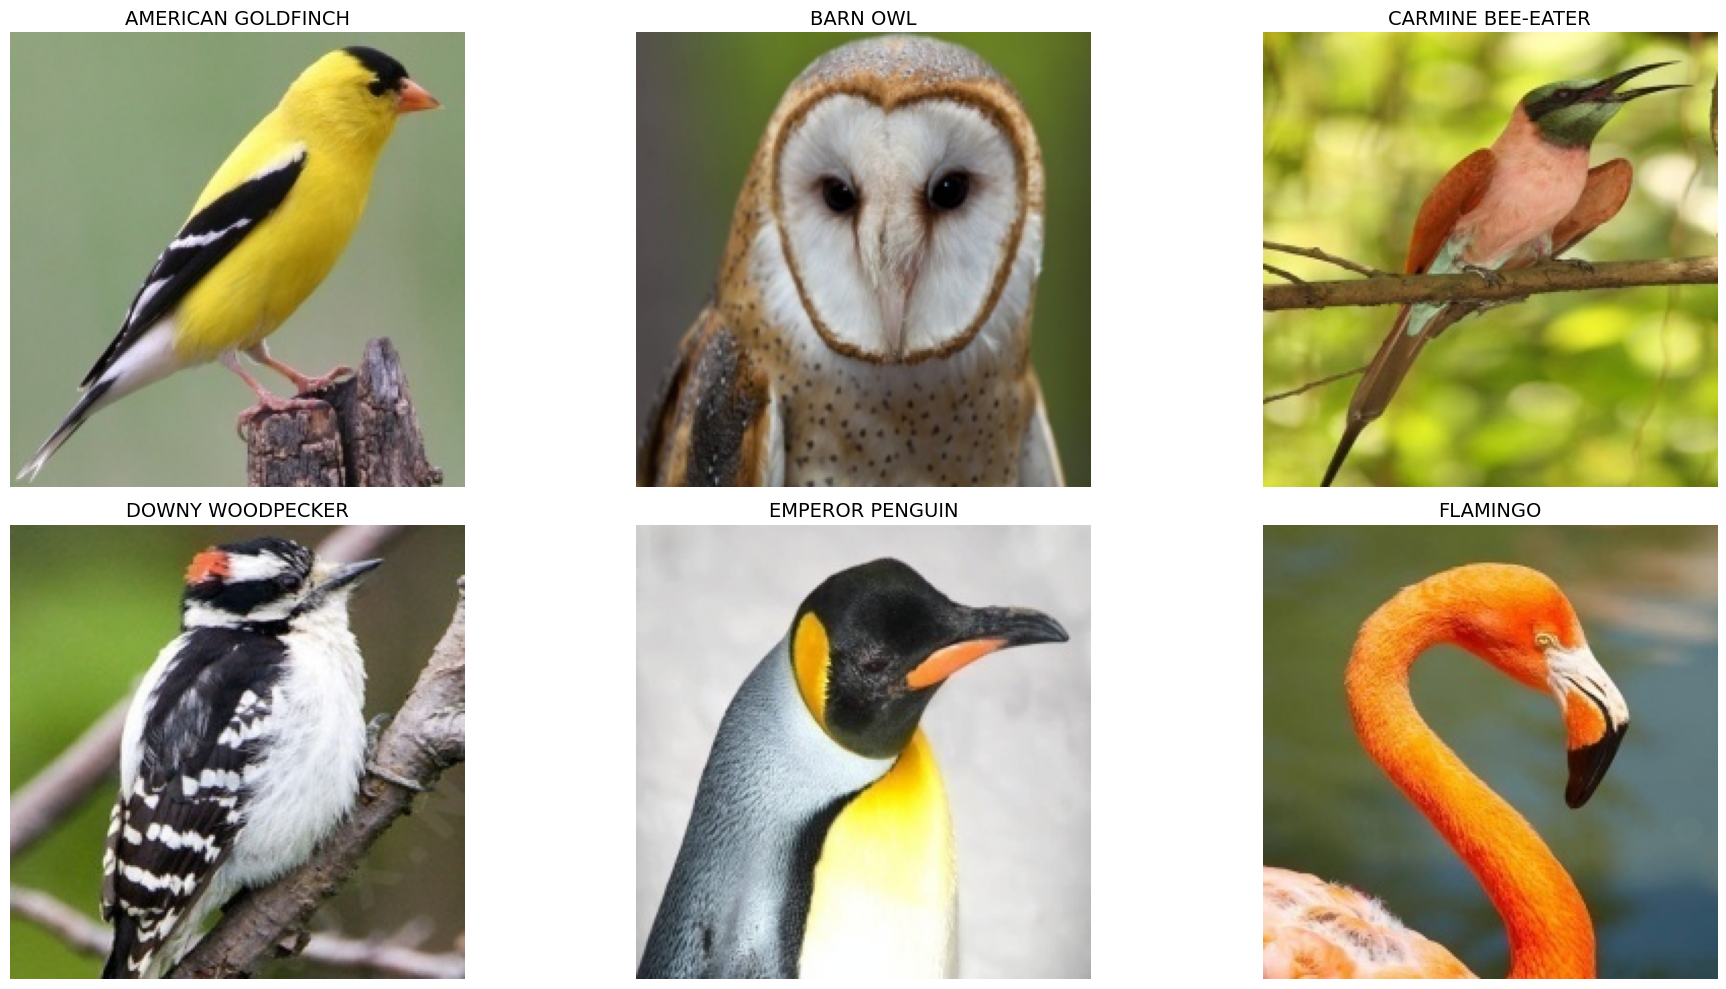

In [ ]:
# Visualizar imágenes aleatorias de entrenamiento por especie
import matplotlib.pyplot as plt
import numpy as np
import random

def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])  # Valores usados para normalizar
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Desnormalizar
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title, fontsize=14)
    plt.axis('off')
    #plt.show()
# Crear un diccionario que mapea cada clase a los índices de sus imágenes en el conjunto de entrenamiento
class_indices = {i: [] for i in range(len(class_names))}

# Construir el mapeo de clases a índices
for idx in range(len(train_dataset)):
    _, label = train_dataset[idx]
    class_indices[label].append(idx)

# Seleccionar una imagen aleatoria por especie
images = []
labels = []

for label in range(len(class_names)):
    indices = class_indices[label]
    random_idx = random.choice(indices)
    img, _ = train_dataset[random_idx]
    images.append(img)
    labels.append(label)

# Mostrar las imágenes con sus etiquetas
num_images = len(images)
plt.figure(figsize=(20, 10))

for i in range(num_images):
    plt.subplot(2, 3, i+1)  # harcodeamos las 6 clases, 2 filas y 3 columnas
    imshow(images[i], title=class_names[labels[i]])

plt.tight_layout()
plt.show()


# Redes Residuales (ResNet)

### ¿Qué son las Redes Residuales?
Las **Redes Residuales (ResNet)** son un tipo de arquitectura de red neuronal convolucional (CNN) que introducen **conexiones residuales** o **atajos (skip connections)** para resolver el problema del **desvanecimiento del gradiente** y la **degradación del rendimiento** en redes muy profundas.

### Problemas en redes profundas
En redes profundas tradicionales, conforme se añaden más capas, se enfrentan dos problemas:
1. **Desvanecimiento del gradiente (Vanishing Gradient)**: En redes con muchas capas, los gradientes pueden volverse muy pequeños durante la retropropagación, dificultando que las capas más profundas aprendan.
2. **Degradación del rendimiento**: A partir de cierto número de capas, añadir más capas puede empeorar el rendimiento del modelo en lugar de mejorarlo.

### ¿Cómo funcionan las ResNet?
Las ResNet solucionan estos problemas utilizando **conexiones de atajo** que permiten que la información fluya sin pasar por todas las capas de la red. Estas conexiones suman la **entrada** de una capa directamente con la **salida** de una capa posterior, lo que facilita el flujo de gradientes y evita el estancamiento del aprendizaje.

### Conexión residual (Skip Connection)
Una **conexión residual** toma la **entrada** de una capa y la suma directamente con la **salida** de una o más capas posteriores. Esto permite que las capas convolucionales aprendan la **diferencia (residuo)** entre la entrada y la salida esperada, en lugar de aprender una transformación completa.

$$	ext{Salida} = F(x) + x$$

Donde:
- **x** es la entrada de la capa.
- **F(x)** es la transformación que realiza la capa convolucional.
- La **salida** es la suma de la transformación **F(x)** y la entrada original **x**.

Ejemplo:

1. **Entrada**: \([1, 2, 3]\)
2. **Primera Convolución + Batch Norm + ReLU**: \([2, 4, 6]\)
3. **Segunda Convolución + Batch Norm**: \([3, 5, 7]\)
4. **Suma**: \([1, 2, 3] + [3, 5, 7] = [4, 7, 10]\)
5. **Salida Final (ReLU)**: \([4, 7, 10]\)

### Bloque Residual
Un **bloque residual** es la unidad básica de una ResNet. Consiste en dos o tres capas convolucionales y una conexión de atajo que suma la entrada original a la salida de las capas convolucionales. Esto ayuda a que el modelo aprenda a mejorar gradualmente sin perder información importante.

Estructura de un bloque residual:
1. **Entrada** → **Capa Convolucional** → **ReLU** → **Capa Convolucional** → **Suma con la Entrada** → **ReLU** → **Salida**.

### Ventajas de las ResNet
1. **Mejora del aprendizaje**: Las conexiones residuales permiten que las capas convolucionales aprendan solo las "diferencias" (residuos) en lugar de las transformaciones completas, lo que facilita el entrenamiento de redes profundas.
2. **Evitan la degradación**: La degradación del rendimiento se evita al permitir que la información original fluya sin ser modificada por todas las capas, mitigando la pérdida de información en redes profundas.
3. **Facilitan el flujo de gradientes**: Al permitir que los gradientes fluyan directamente a través de las conexiones de atajo, ResNet evita el problema del desvanecimiento del gradiente en redes profundas.

### Aplicaciones de ResNet
Las Redes Residuales se han utilizado ampliamente en tareas de **clasificación de imágenes**, **detección de objetos**, **segmentación semántica**, entre otras. Algunas de las versiones más utilizadas incluyen ResNet-18, ResNet-34, ResNet-50 y ResNet-101, donde el número indica la cantidad de capas en la red.

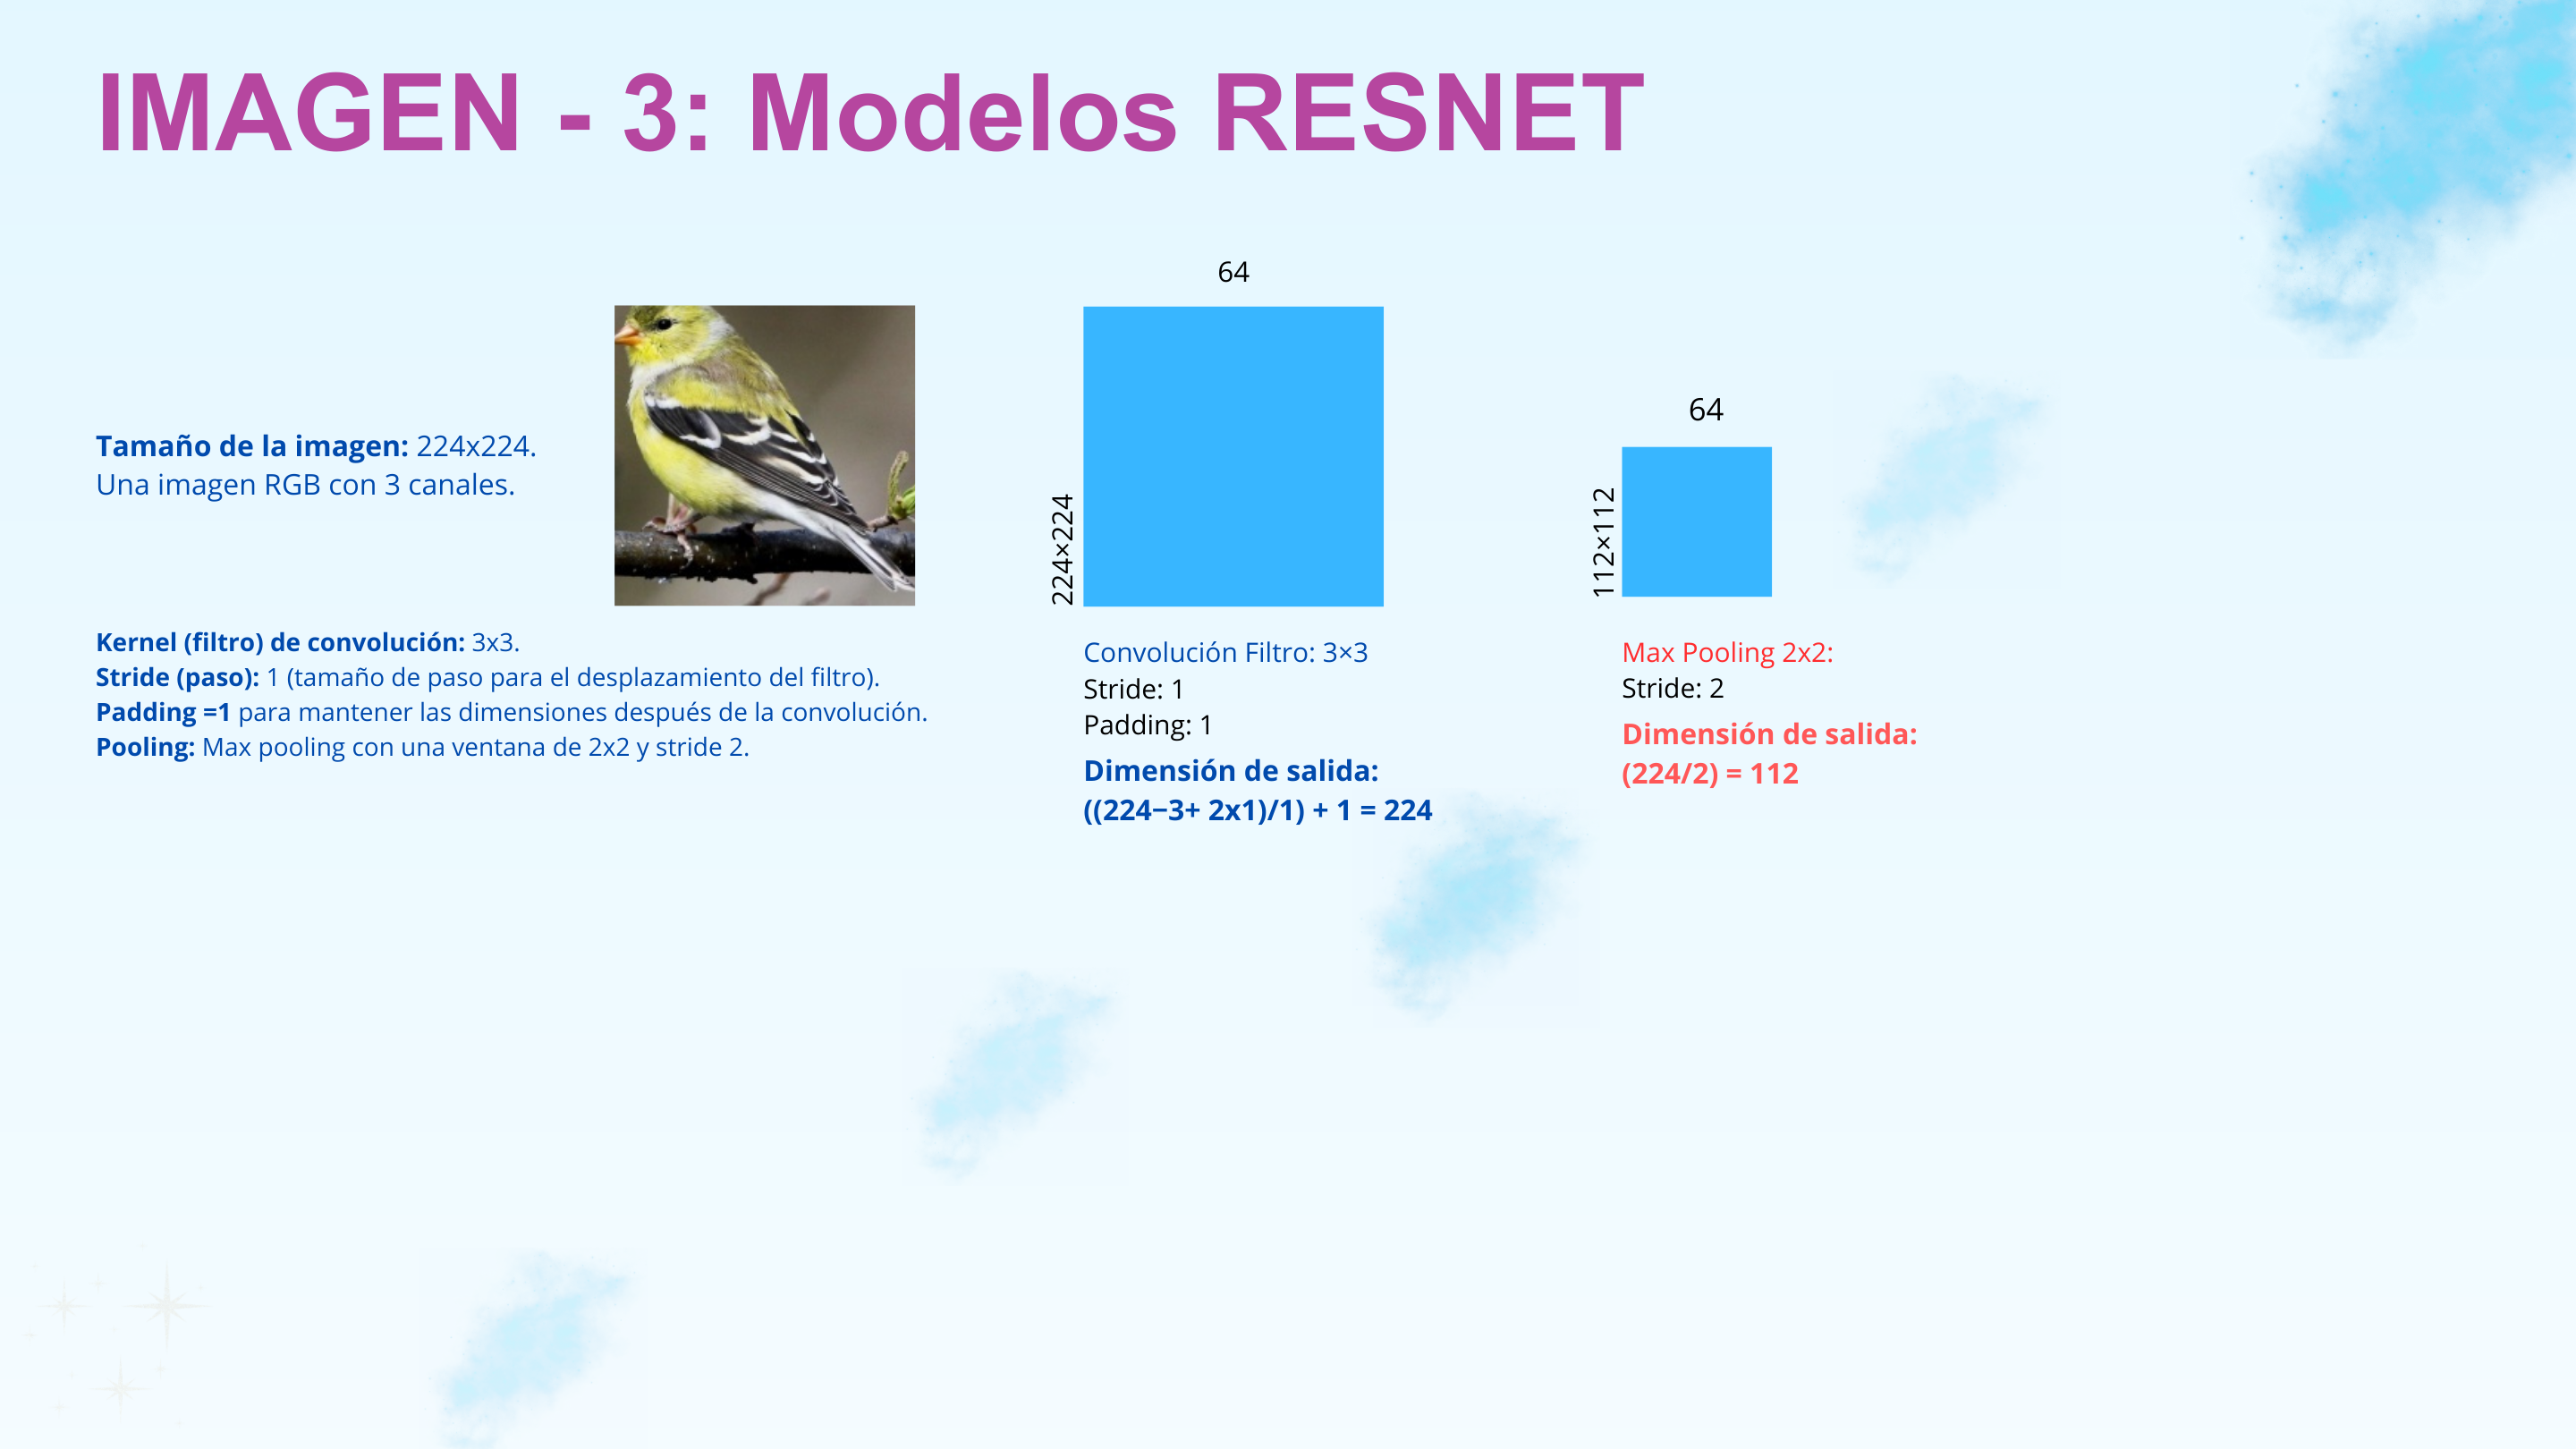

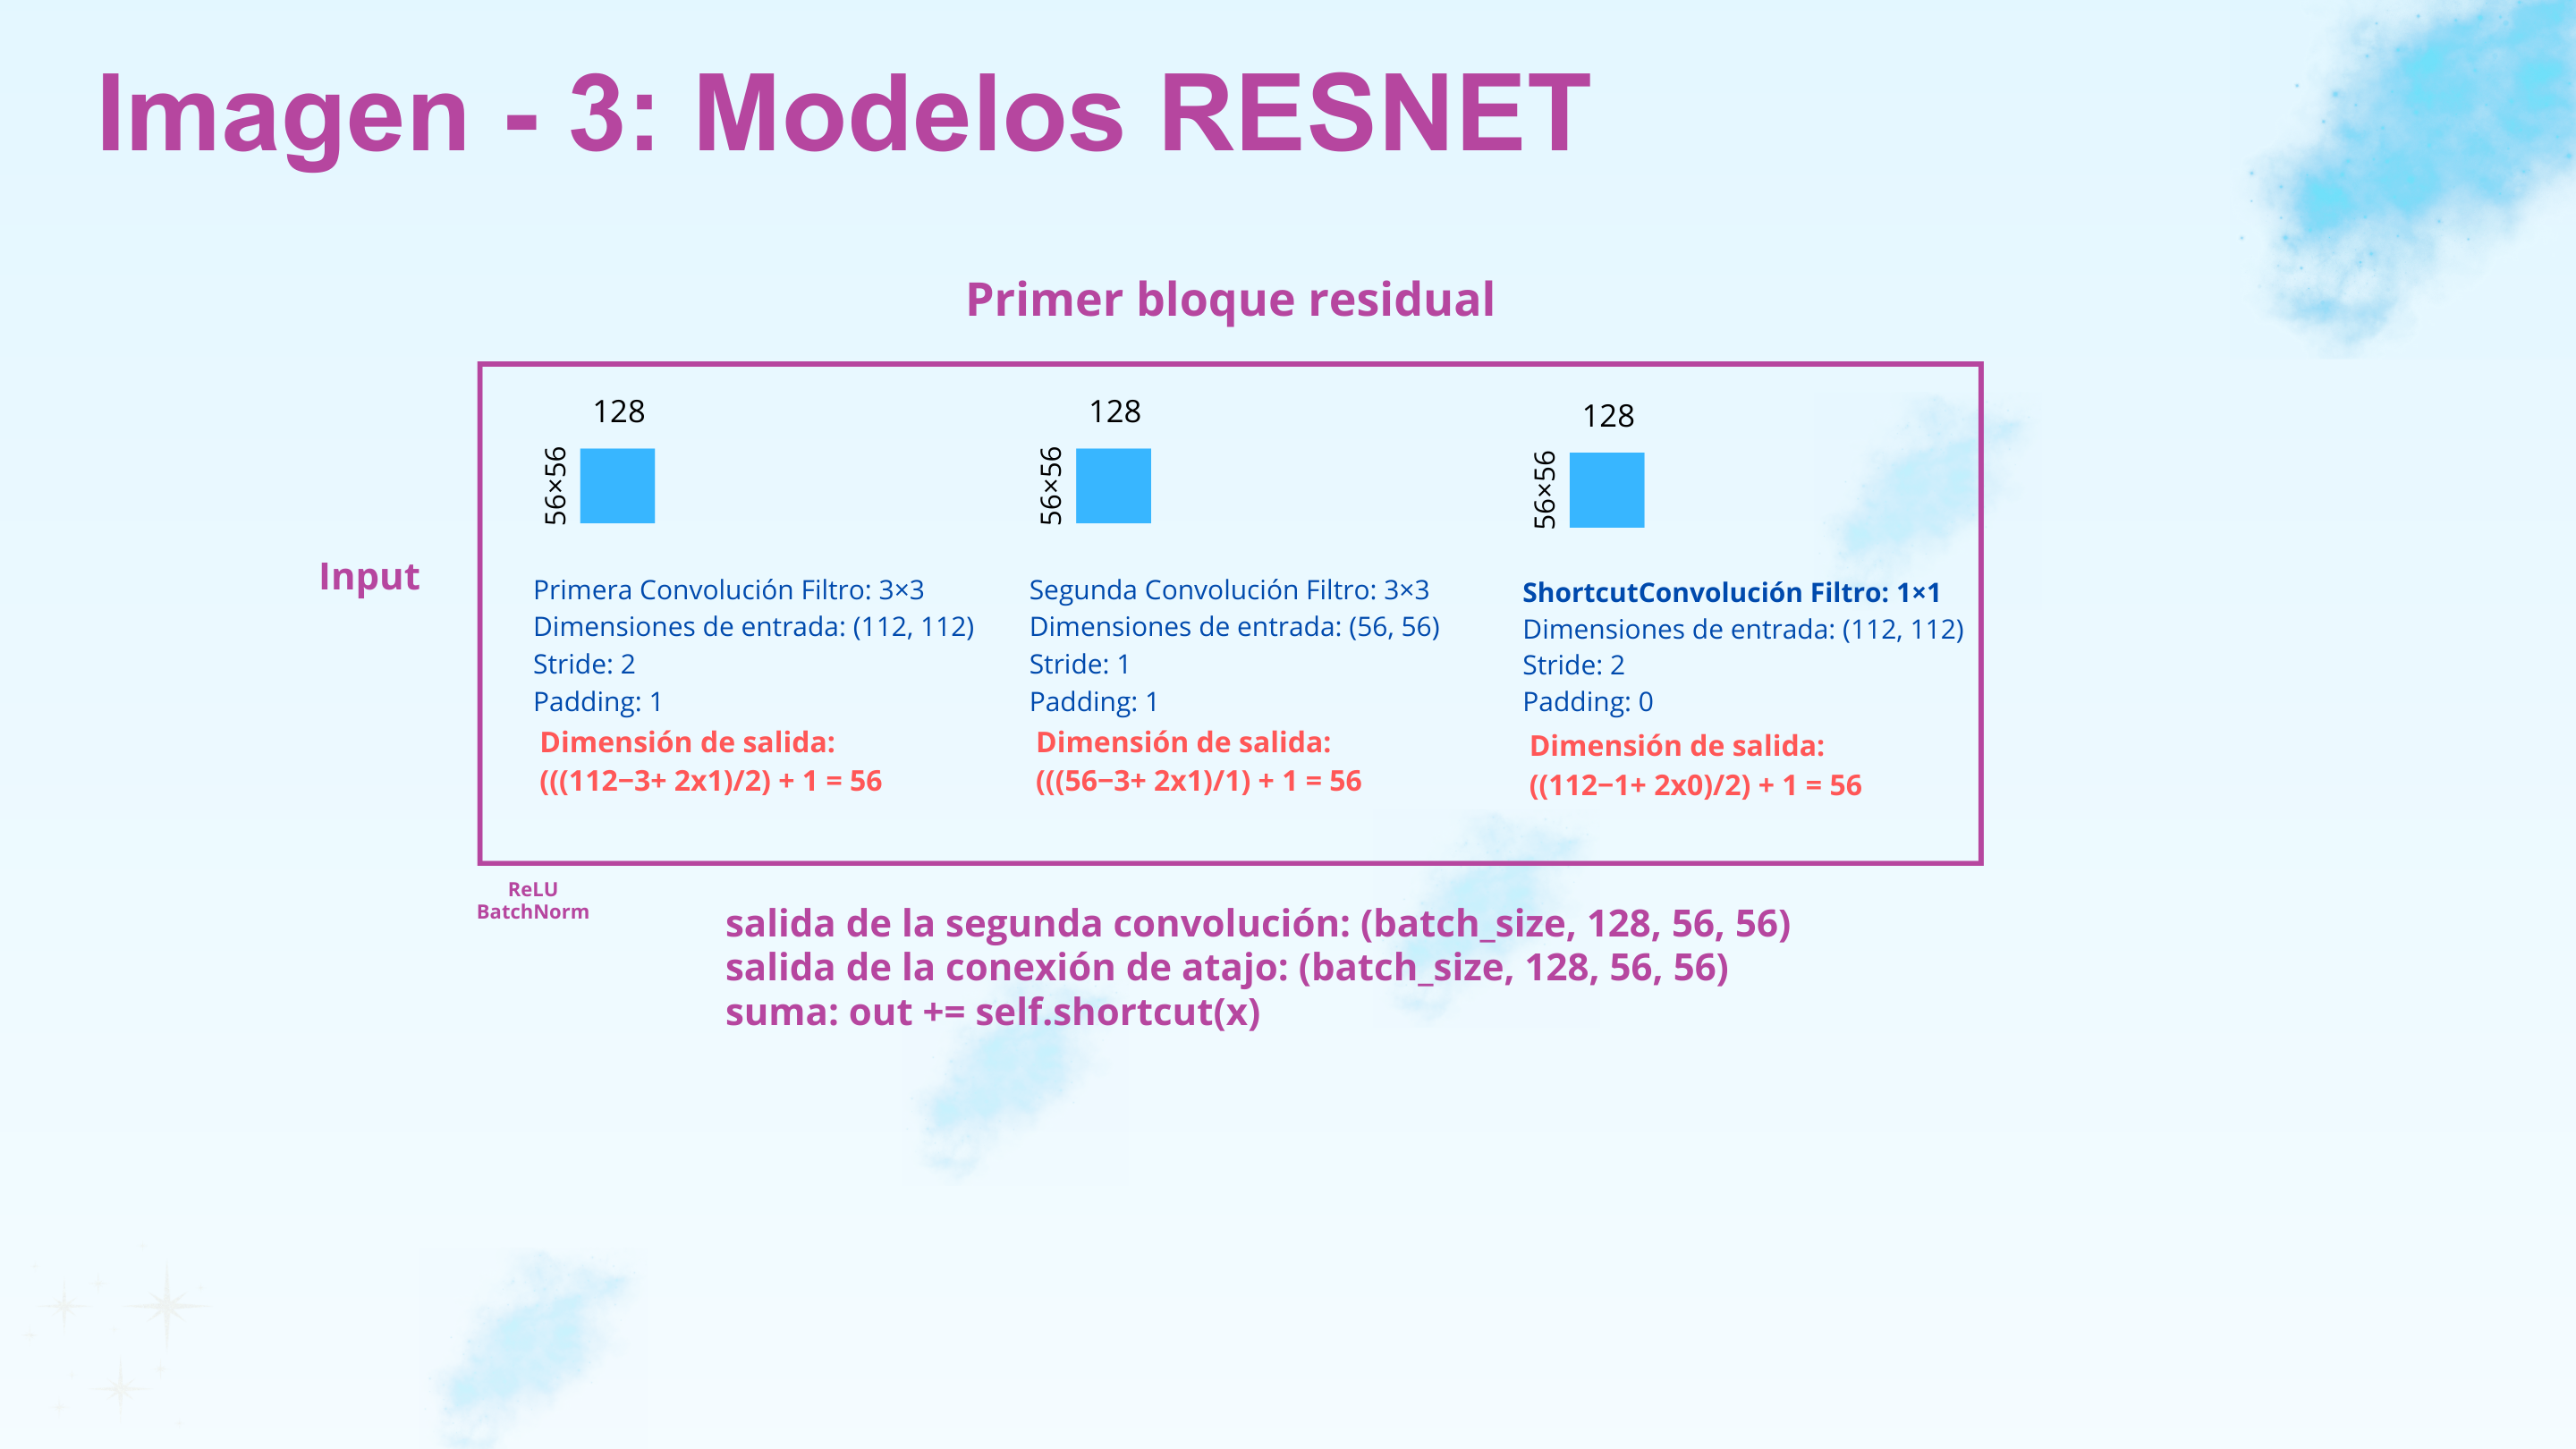

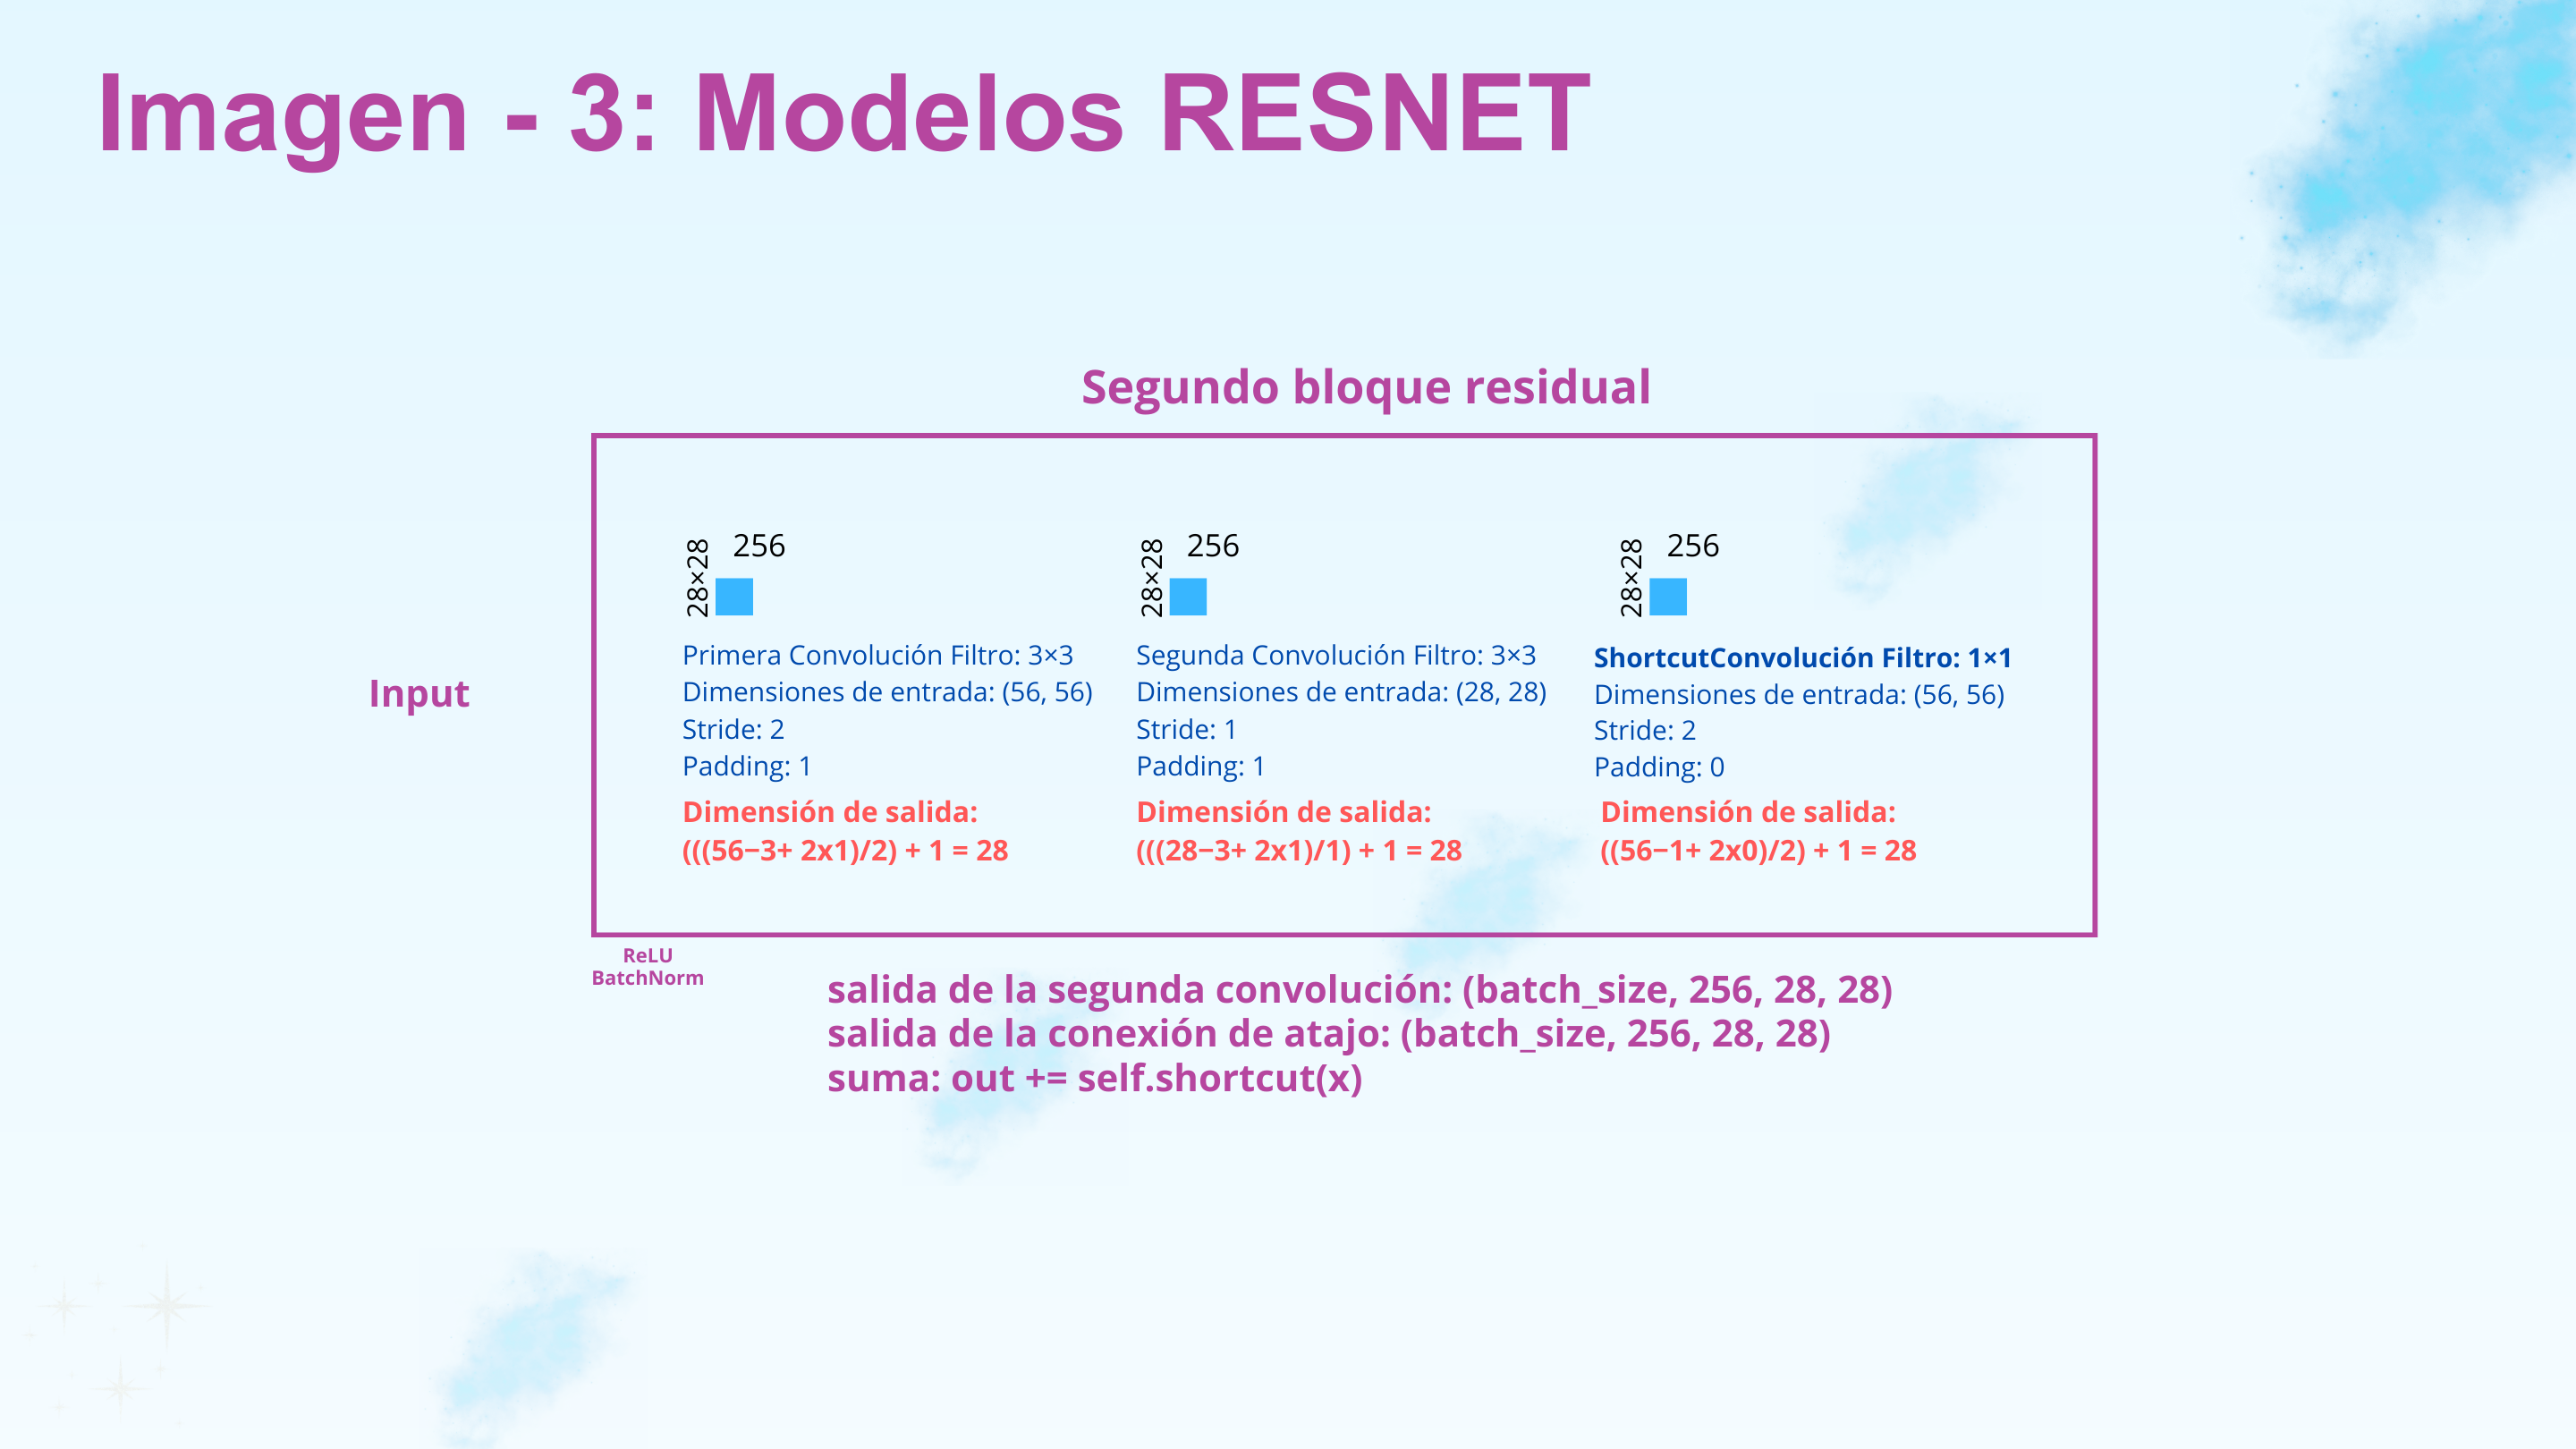

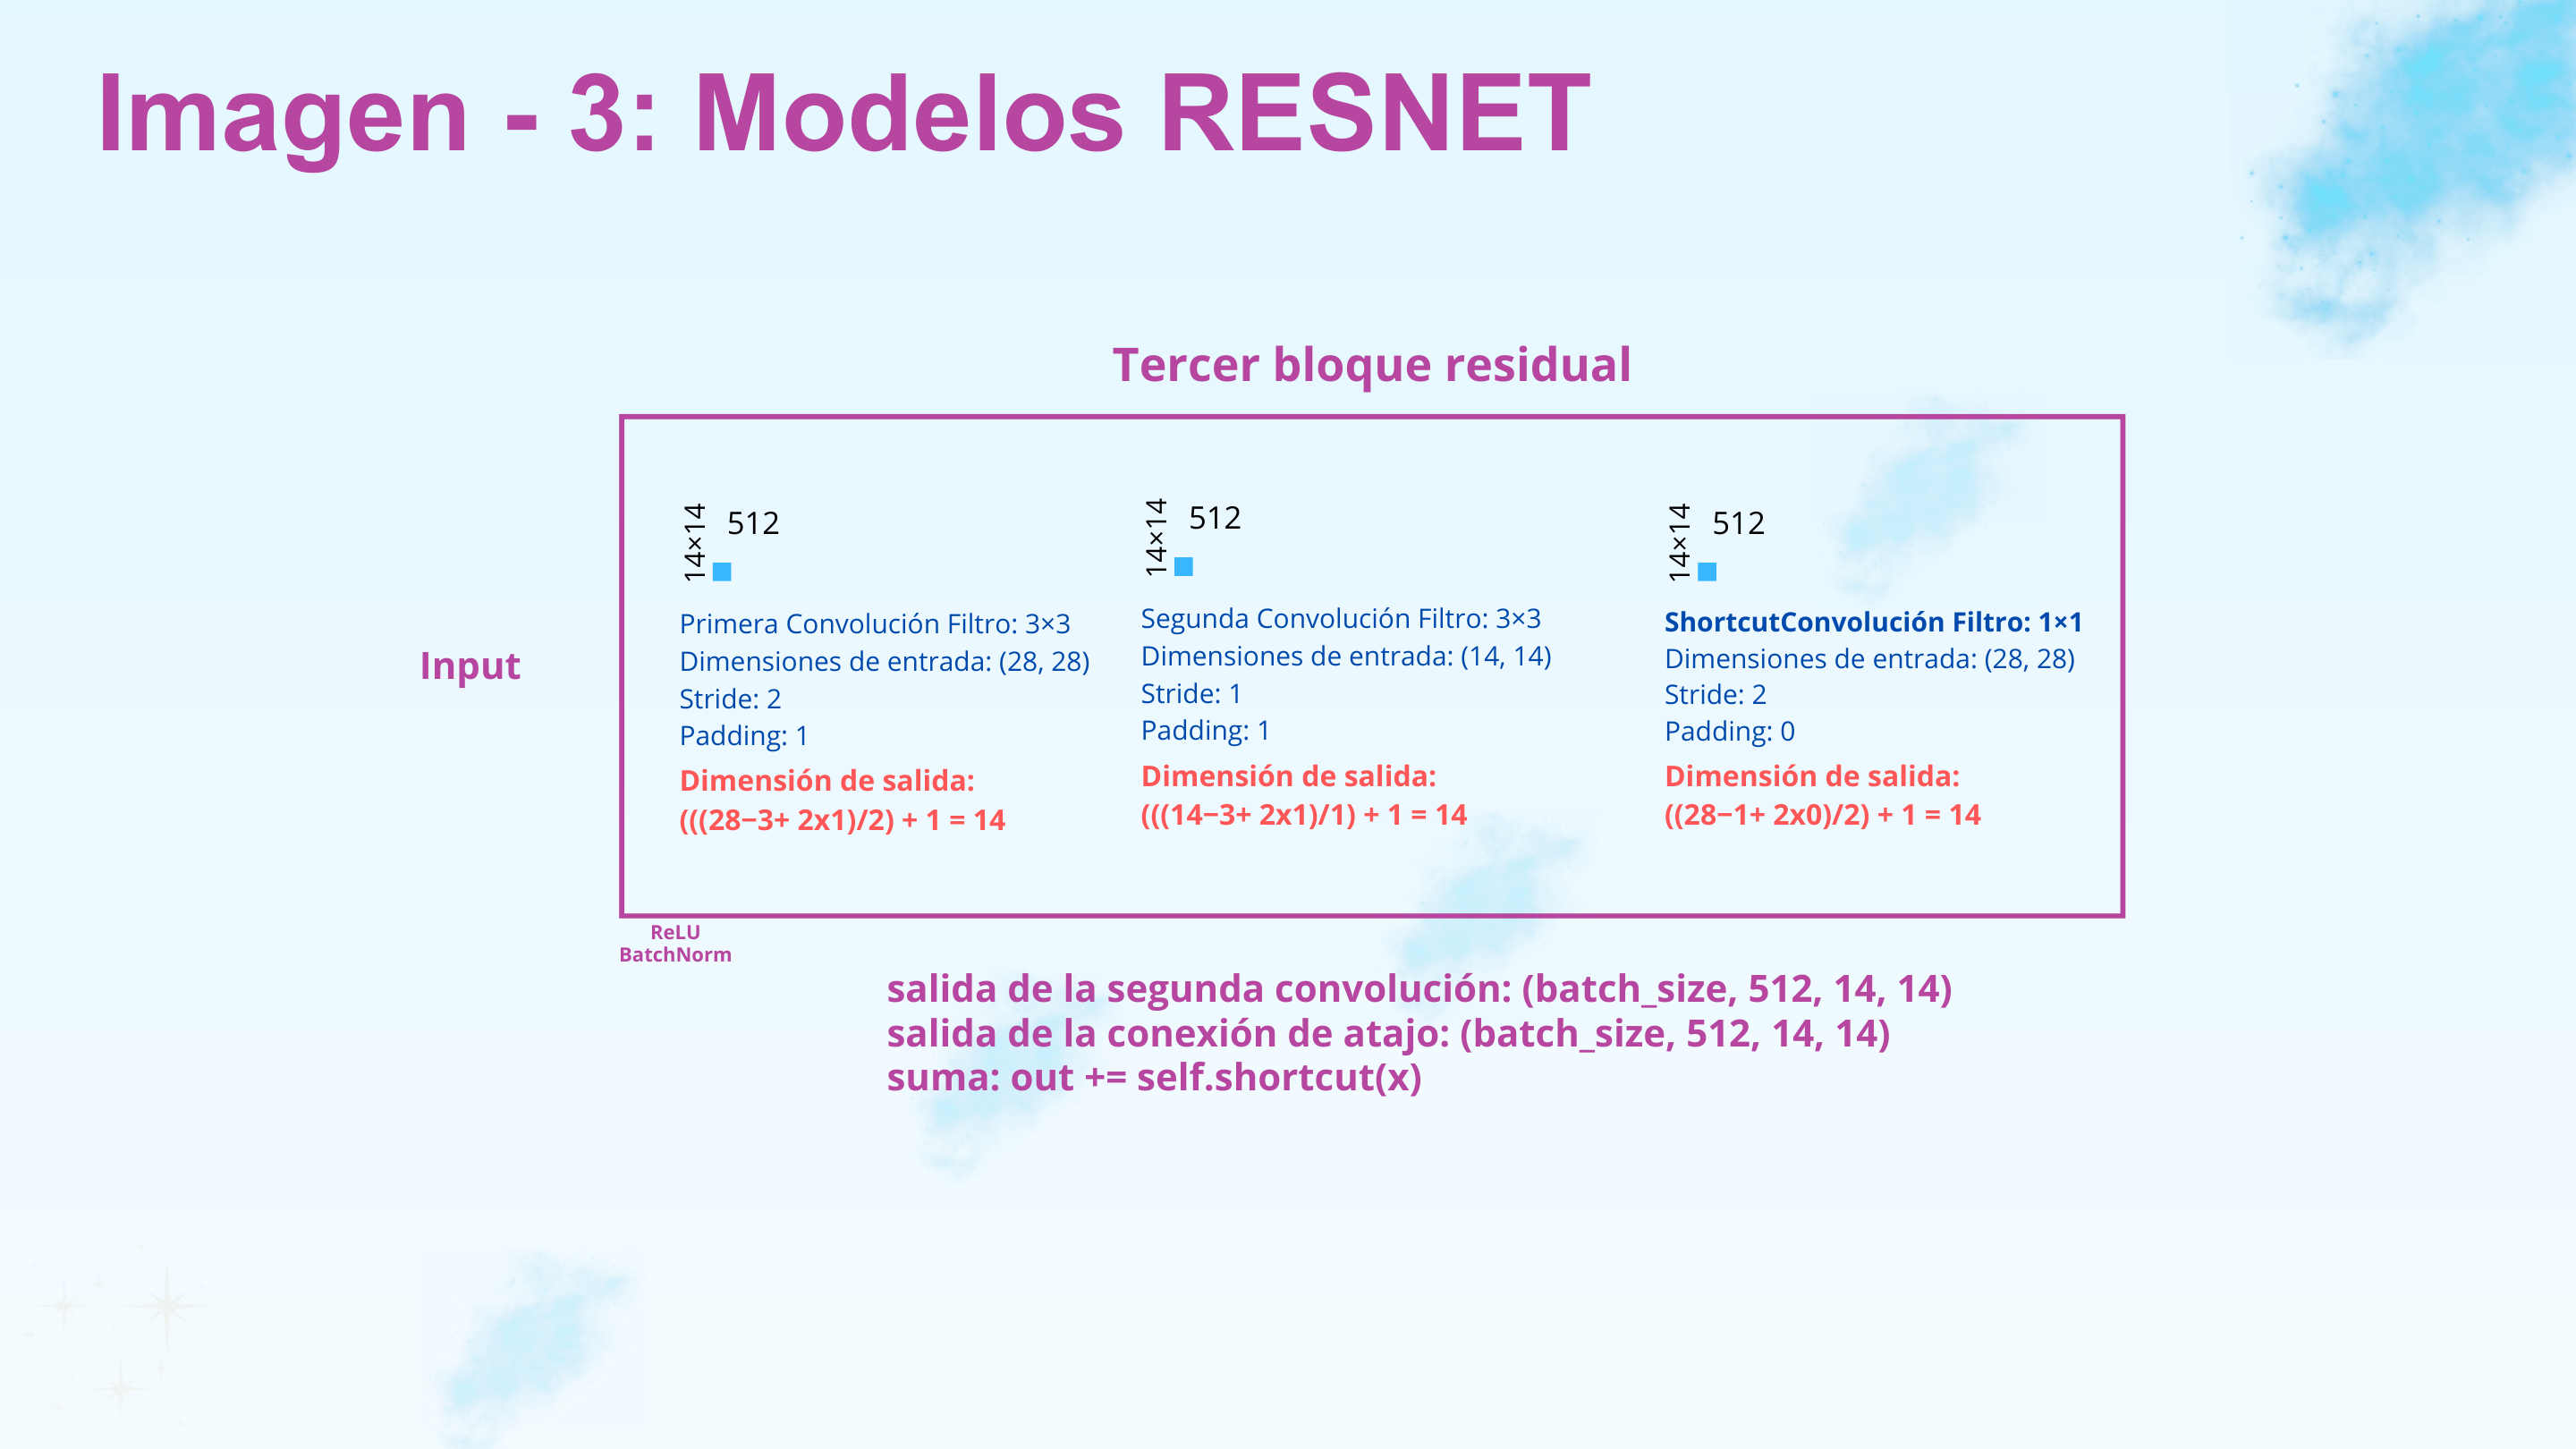

In [ ]:
import torch
import torch.nn as nn

# Definir un bloque residual
class BloqueResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BloqueResidual, self).__init__()
        # Primera convolución
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # Segunda convolución
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Conexión de atajo (skip connection)
        # Esta sección permite que la entrada original se salte (skip) el bloque convolucional y se sume directamente a la salida.
        # Esto facilita el aprendizaje en redes profundas, ya que la red puede aprender ajustes residuales sobre la entrada original.
        self.shortcut = nn.Sequential()
        # Si la entrada y salida tienen diferentes dimensiones (debido al stride o número de canales), ajustamos la entrada para que tenga las mismas dimensiones que la salida.
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),  # Ajuste de dimensiones mediante convolución 1x1
                nn.BatchNorm2d(out_channels)  # Normalización por lotes para mantener la coherencia estadística
            )

    def forward(self, x):
        # Paso por el bloque convolucional
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # Sumar la entrada con la salida del bloque convolucional
        # Esta suma ayuda a evitar el problema del desvanecimiento del gradiente y facilita el aprendizaje de la red.
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Definir la red ResNet utilizando los bloques residuales
class ResNetCNNModel(nn.Module):
    def __init__(self, num_classes=6):
        super(ResNetCNNModel, self).__init__()
        self.features = nn.Sequential(
            # Primera capa de convolución (no residual)
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (224x224) -> (112x112)
            # recordar desde aqui se utilizan convoluciones con stride mayor 1 para reducir dimensionalidad

            # Bloques residuales
            BloqueResidual(64, 128, stride=2),  # Reduce  (112x112) -> (56x56)
            BloqueResidual(128, 256, stride=2),  # Reduce (56x56) -> (28x28)
            BloqueResidual(256, 512, stride=2),  # Reduce (28x28) -> (14x14)
        )

        # Capas totalmente conectadas
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 14 * 14, 512),  # Aplanar y conectar a una capa totalmente conectada
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)  # Capa de salida con activación lineal
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Aplanar el tensor
        x = self.classifier(x)
        return x

# Crear una instancia del modelo ResNet
model = ResNetCNNModel(num_classes=6)

# Simular una imagen de entrada de 224x224 con 3 canales (RGB)
input_image = torch.randn(1, 3, 224, 224)

# Pasar la imagen por el modelo
output = model(input_image)

# Imprimir el tamaño de salida final
print(f"Tamaño de salida final: {output.shape}")  # Debe ser torch.Size([1, 6])

Tamaño de salida final: torch.Size([1, 6])


In [ ]:
# Definir el dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Usando el dispositivo:", device)
model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Usando el dispositivo: cuda:0


In [ ]:
# Entrenar el modelo
num_epochs = 25

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Entrenamiento
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        # Mover los inputs y labels al dispositivo
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Inicializar gradientes
        optimizer.zero_grad()

        # Forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        # Estadísticas
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    print(f'Pérdida de entrenamiento: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # Validación
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Mover inputs y labels al dispositivo para la validación
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)

    val_loss = val_running_loss / len(val_dataset)
    val_acc = val_running_corrects.double() / len(val_dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f'Pérdida de validación: {val_loss:.4f} Acc: {val_acc:.4f}\n')


Epoch 1/25
----------
Pérdida de entrenamiento: 10.8981 Acc: 0.4228
Pérdida de validación: 5.0239 Acc: 0.5460

Epoch 2/25
----------
Pérdida de entrenamiento: 1.3075 Acc: 0.7006
Pérdida de validación: 0.9464 Acc: 0.7669

Epoch 3/25
----------
Pérdida de entrenamiento: 0.9228 Acc: 0.7562
Pérdida de validación: 1.5744 Acc: 0.7239

Epoch 4/25
----------
Pérdida de entrenamiento: 0.6713 Acc: 0.8210
Pérdida de validación: 1.1385 Acc: 0.8221

Epoch 5/25
----------
Pérdida de entrenamiento: 0.3824 Acc: 0.8750
Pérdida de validación: 0.6094 Acc: 0.8344

Epoch 6/25
----------
Pérdida de entrenamiento: 0.1805 Acc: 0.9352
Pérdida de validación: 0.4878 Acc: 0.8896

Epoch 7/25
----------
Pérdida de entrenamiento: 0.1148 Acc: 0.9583
Pérdida de validación: 0.4161 Acc: 0.9080

Epoch 8/25
----------
Pérdida de entrenamiento: 0.0790 Acc: 0.9861
Pérdida de validación: 0.5002 Acc: 0.8712

Epoch 9/25
----------
Pérdida de entrenamiento: 0.1414 Acc: 0.9707
Pérdida de validación: 0.5298 Acc: 0.8957

Epoch 10/

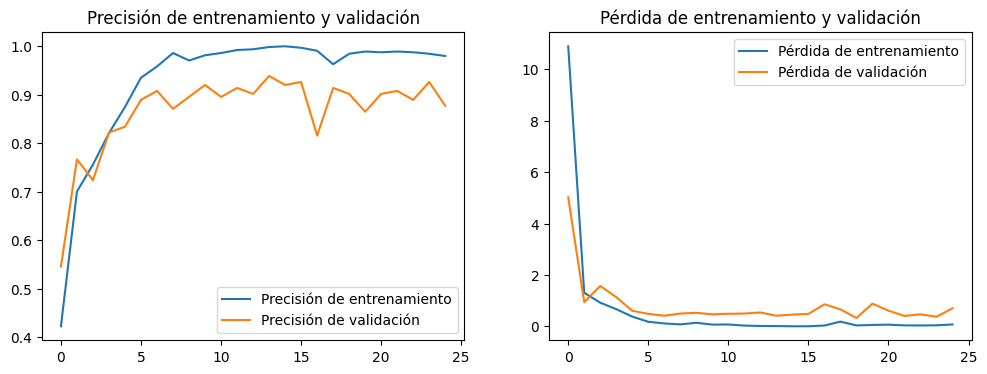

In [ ]:
# Visualizar las curvas de precisión y pérdida
epochs_range = range(num_epochs)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Precisión de entrenamiento')
plt.plot(epochs_range, val_accuracies, label='Precisión de validación')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Pérdida de entrenamiento')
plt.plot(epochs_range, val_losses, label='Pérdida de validación')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y validación')
plt.show()


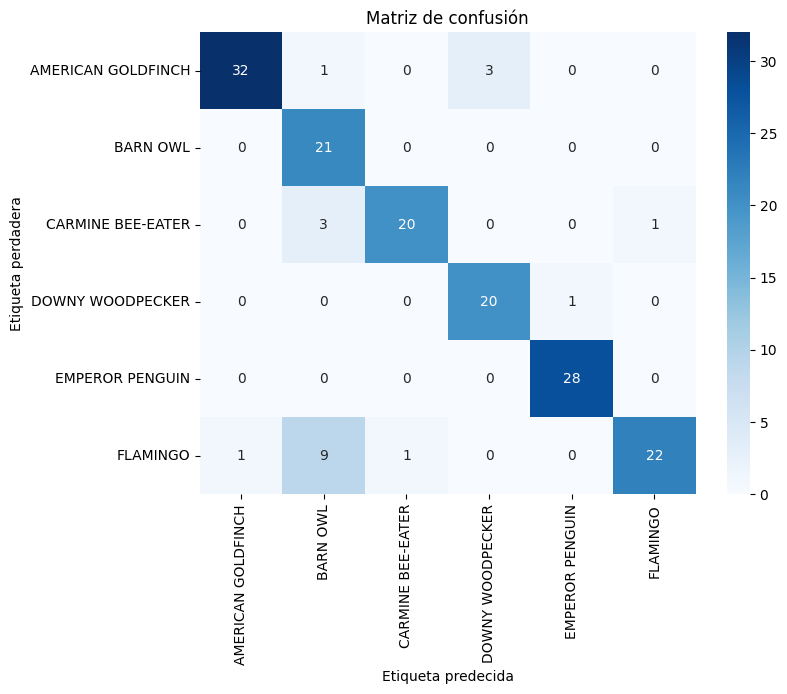

In [ ]:
# matriz de confusión
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Configurar el modelo en modo de evaluación
model.eval()

# Listas para almacenar las etiquetas verdaderas y las predicciones
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# creamos la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Etiqueta perdadera')
plt.xlabel('Etiqueta predecida')
plt.title('Matriz de confusión')
plt.show()


### TODO: Entrenar sin skipConnection

**Modificar el Bloque Residual: Comenta o elimina la línea de código que suma la salida del bloque convolucional con la entrada (out += self.shortcut(x)).**

Al eliminar esta conexión, el modelo deberá aprender todas las características directamente en cada capa convolucional del bloque, sin sumar la información original de la entrada.

**Objetivo**: Observar las diferencias en rendimiento y convergencia entre el modelo que usa skip connection y el que no la usa. Compara las métricas de precisión y pérdida para entender si la skip connection realmente aporta mejoras en este caso específico, o si el modelo es capaz de entrenar de manera efectiva sin ella.



Preguntas:

1. **¿Qué problema resuelven las conexiones residuales en redes profundas?**
2. **¿Por qué sumamos la entrada y la salida en un bloque residual?**
3. **¿Cómo ayudan las ResNet a evitar la pérdida de información en redes profundas?**
4. **¿Qué ventaja tienen las ResNet frente a redes más simples cuando aumentamos la cantidad de capas?**
5. **¿Qué hace la normalización por lotes (Batch Normalization) después de cada convolución?**
6. **¿Qué pasaría si no ajustamos las dimensiones en las conexiones residuales cuando cambia el tamaño o los canales de las capas?**
7. **¿Cómo nos ayuda la matriz de confusión a evaluar el rendimiento del modelo?**
